#### The Packages

In [2]:
import pandas as pd
import numpy as np
import os
import tempfile
from datetime import datetime
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from math import sqrt,exp
from google.colab.patches import cv2_imshow
import helper as hp
from __future__ import division
import math
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GroupShuffleSplit

#### Drive mounting and directory setting

In [1]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [3]:
project_dir = "/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/"
working_dir = project_dir + "SRC/"
image_dir = project_dir + "data/images_cleaned/"
cementum_dir = project_dir + "data/Cementum_only_images/"
%cd {working_dir} 
%pwd

[Errno 2] No such file or directory: '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC/'
/content


'/content'

#### Load the data

In [ ]:
data = pd.read_csv(project_dir + 'data/clean_meta.csv')
print(data.shape)
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
group_names = ['<19', '20 - 29', '30-39', '40-49','50-59','60-69','70-79','80-99']
data['age_groups'] = pd.cut(data['Age'], bins, labels=group_names)
data = data.drop('Unnamed: 0', axis= 1)
data.head(10)

(698, 8)


,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption,age_groups
0,2,12.0,46.00,2.0,140,002_12_2_46_0140.tif,8.5,40-49
1,2,12.0,46.00,2.0,373,002_12_2_46_0373.tif,8.5,40-49
2,6,22.0,46.00,2.0,152,006_22_2_46_0152.tif,8.5,40-49
3,6,22.0,46.00,2.0,153,006_22_2_46_0153.tif,8.5,40-49
4,6,22.0,46.00,2.0,154,006_22_2_46_0154.tif,8.5,40-49
5,10,35.0,63.25,0.0,289,010_35_NA_63.25_0289.tif,11.0,60-69
6,10,35.0,63.25,0.0,290,010_35_NA_63.25_0290.tif,11.0,60-69
7,10,35.0,63.25,0.0,395,010_35_NA_63.25_0395.tif,11.0,60-69
8,11,34.0,47.50,1.0,179,011_34_1_47.5_0179.tif,10.0,40-49
9,11,34.0,47.50,1.0,180,011_34_1_47.5_0180.tif,10.0,40-49


#### Generator that puts slices into corresponding arrays

In [ ]:
def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (255, 255, 255, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [ ]:
class ToothdataGenerator():

  def __init__(self, df):
        self.df = df

  def preprocess_image(self, img_path, IMG_SIZE = 224, training = False):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = tf.keras.preprocessing.image.load_img(img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        if training == True:
          img_contr_obj=ImageEnhance.Contrast(im)
          img_sharp_obj=ImageEnhance.Sharpness(im)
          factor=2.5
          im=img_contr_obj.enhance(factor)
          im = img_sharp_obj.enhance(factor)
          im = np.array(im).astype(np.float32) / 255.0
          im = tf.keras.preprocessing.image.random_brightness(im, brightness_range=(0.9, 1.1))
          im = tf.keras.preprocessing.image.random_shear(im, intensity= 0.00005)
          im = tf.keras.preprocessing.image.random_zoom(im, (0.9, 1.1))
        else:
          im = np.array(im).astype(np.float32) / 255.0
        return im
  
  def generate_images(self, image_idx, is_training, batch_size=16, IMG_SIZE = 224, image_training = False):
    crop_1, crop_2, crop_3, crop_4, ages = [], [], [], [], []
    while True:
      for idx in image_idx:
        slice = self.df.iloc[idx]
        age = slice['Age'],
        ages.append(age)
        image = slice['ImgName']
        im = self.preprocess_image(cementum_dir + image, IMG_SIZE = IMG_SIZE, training = image_training)  
        imgwidth, imgheight = im.shape[0], im.shape[1]
        height = imgheight // 1
        width = imgwidth // 4
        for i in range(0, 1):
          for j in range(0, 4):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            im = tf.keras.preprocessing.image.array_to_img(im)
            a = im.crop(box)
            final = resize(a, 224, 224)
            final = tf.keras.preprocessing.image.img_to_array(final)
            if j == 0:
                crop_1.append(final)
            if j == 1:
                crop_2.append(final)
            if j == 2:
                crop_3.append(final)
            if j == 3:
                crop_4.append(final)

            
            # yielding condition
        if len(ages) >= batch_size:
          yield [np.array(crop_1),[np.array(crop_2),np.array(crop_3), np.array(crop_4)]] , np.array(ages)
          crop_1, crop_2, crop_3, crop_4, ages = [], [], [], [], []
    
      if not is_training:
        break

In [ ]:
datagenerator = ToothdataGenerator(data)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit 
train, test = next(GroupShuffleSplit(train_size=0.7, n_splits=2, random_state=7).split(data, groups=data['ID']))
train_data= data.iloc[train]
test_data = data.iloc[test]
test_idx = test_data.index
train, valid = next(GroupShuffleSplit(train_size=0.7, n_splits=2, random_state=7).split(train_data, groups=train_data['ID']))
train_data_true= train_data.iloc[train]
train_idx = train_data_true.index
valid_data = train_data.iloc[valid]
valid_idx = valid_data.index

In [ ]:
batch_size = 32
valid_batch_size = 32
test_batch_size = 1

train_generator = datagenerator.generate_images(train_idx, is_training= True, batch_size= batch_size, image_training= True, IMG_SIZE= 224)
valid_generator = datagenerator.generate_images(valid_idx, is_training= True, batch_size= valid_batch_size, IMG_SIZE= 224)
test_generator = datagenerator.generate_images(test_idx, is_training= False, batch_size= test_batch_size, IMG_SIZE= 224)

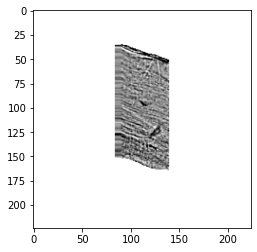

In [ ]:
playtest = next(train_generator)[0][0][4]

image_to_play = tf.keras.preprocessing.image.array_to_img(playtest)
plt.imshow(image_to_play)

#### Multi-input model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
base = ResNet50(include_top= False, weights= 'imagenet', pooling= 'max')
base.trainable = True
fine_tune_at = 100
for layer in base.layers[:fine_tune_at]:
  layer.trainable =  False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def model_constructor_2(input_shape, num_classes):
  input_1 = keras.Input(shape=(input_shape), name="Cropped_1")
  res_1 = base(input_1)
  input_2 = keras.Input(shape=(input_shape), name="Cropped_2")
  res_2 = base(input_2)
  input_3 = keras.Input(shape=(input_shape), name="Cropped_3")
  res_3 = base(input_3)
  input_4 = keras.Input(shape=(input_shape), name="Cropped_4")
  res_4 = base(input_4)
  combined = layers.concatenate([res_1, res_2, res_3, res_4])
  x = layers.Dense(2048)(combined)
  prediction = layers.Dense(num_classes, name = "Age_pred")(x)
  return Model(inputs = [input_1, input_2, input_3, input_4], outputs= prediction)

In [ ]:
model_2 = model_constructor_2(input_shape=(224, 224, 3), num_classes= 1)

In [ ]:
model_2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Cropped_1 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_2 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_3 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Cropped_4 (InputLayer)          [(None, 224, 224, 3) 0                                            
_______________________________________________________________________________________

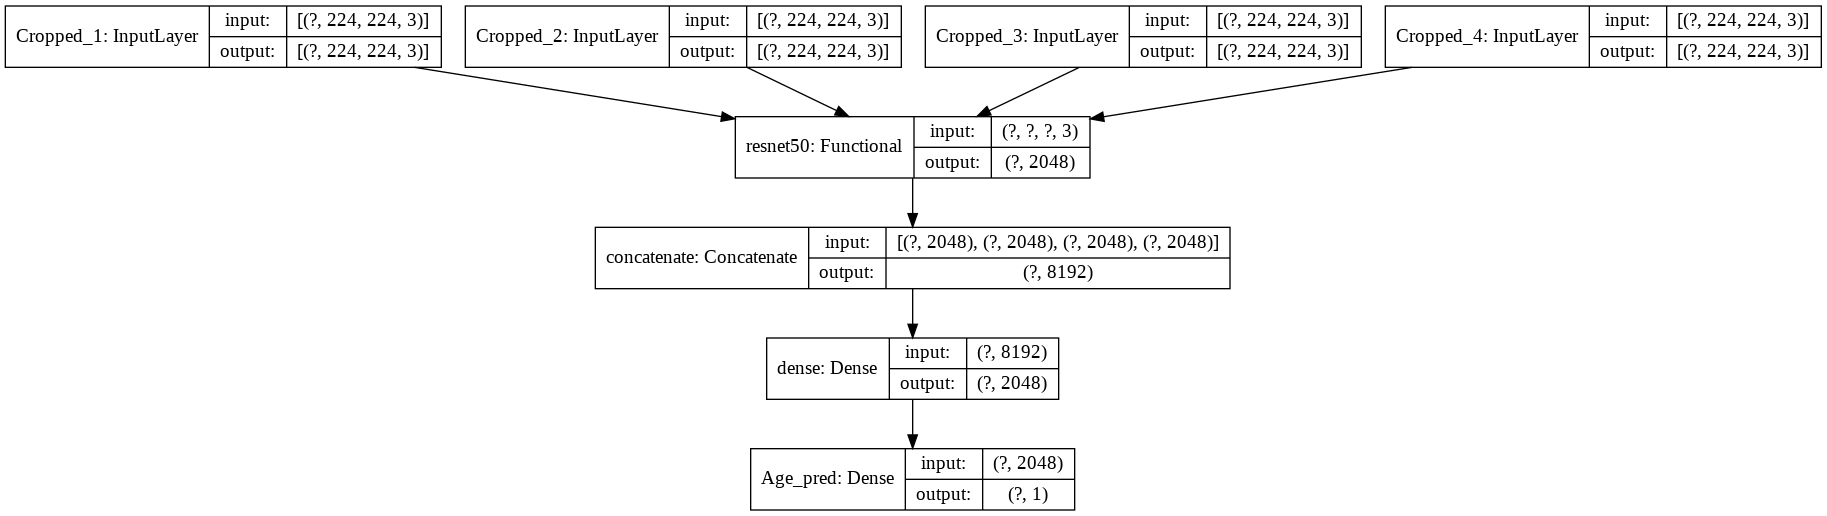

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

#### Compile and Run the Model

In [ ]:
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_4_slices.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/models/checkpoint_multi_input_cleaned_images.ckpt


In [ ]:
model_2.load_weights(latest)

In [ ]:
#Loss function needs to be the Mean_squared error
loss = "MeanSquaredError"

#metrics for measurement
metrics = ['RootMeanSquaredError']

#Optimizer is going to the Adam, because it is the best performing
Optimizer = Adam(learning_rate= 1e-5)

In [ ]:
model_2.compile(optimizer= Optimizer, loss = loss, metrics= metrics)

In [ ]:
#model checkpoint
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_4_slices.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
#EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-7)
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger("training_sliced_images.log", append = True)

epochs = 10
callbacks = [reduce_lr, csv_logger, early_stop, checkpoint]

In [ ]:
history = model_2.fit(train_generator,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=len(valid_idx)//valid_batch_size
                    )

Epoch 1/10
11/11 [==============================] - 281s 26s/step - loss: 703.9294 - root_mean_squared_error: 26.5317 - val_loss: 534.8409 - val_root_mean_squared_error: 23.1266
Epoch 2/10
11/11 [==============================] - 251s 23s/step - loss: 322.5140 - root_mean_squared_error: 17.9587 - val_loss: 251.8386 - val_root_mean_squared_error: 15.8694
Epoch 3/10
11/11 [==============================] - 250s 23s/step - loss: 285.5057 - root_mean_squared_error: 16.8969 - val_loss: 222.4694 - val_root_mean_squared_error: 14.9154
Epoch 4/10
11/11 [==============================] - 254s 23s/step - loss: 199.7322 - root_mean_squared_error: 14.1327 - val_loss: 311.5247 - val_root_mean_squared_error: 17.6501
Epoch 5/10
11/11 [==============================] - 247s 22s/step - loss: 68.3256 - root_mean_squared_error: 8.2659 - val_loss: 237.0892 - val_root_mean_squared_error: 15.3977
Epoch 6/10
11/11 [==============================] - 247s 22s/step - loss: 73.4557 - root_mean_squared_error: 8.5

In [ ]:
model_2.save('/gdrive/My Drive/Propulsion_Academy/TCA_Project/TCA_project_Tomek_Thomas/tooth-annulation/models/Thomas_model.h5')

#### Plot the results

In [ ]:
pred = model_2.predict(test_generator, steps=len(test_idx)//test_batch_size)

[Text(0, 0.5, 'Predicted Age'),
 Text(0.5, 0, 'True Age'),
 Text(0.5, 1.0, 'True Age vs Predicted Age')]

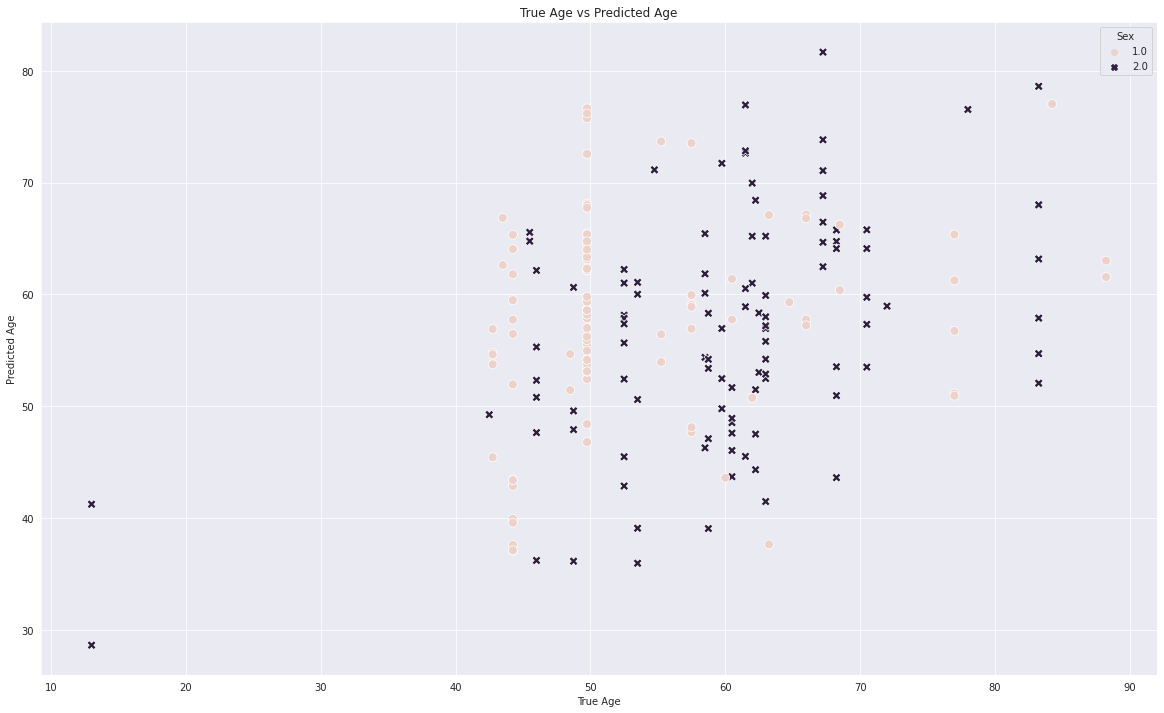

In [ ]:
fig = plt.gcf()
sns.set_style("darkgrid")
fig.set_size_inches(20, 12)
test_labels = data.iloc[test_idx]
ax = sns.scatterplot(x = test_labels['Age'], y = pred.flatten(), hue = test_labels['Sex'], style = test_labels['Sex'], edgecolor = 'w', s = 80,)
ax.set(xlabel='True Age', ylabel='Predicted Age', title = "True Age vs Predicted Age")

### Sliced Images with additional Features

#### Generator

In [ ]:
class MultidataGenerator():

  def __init__(self, df):
        self.df = df

  def preprocess_image(self, img_path, IMG_SIZE = 224, training = False):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = tf.keras.preprocessing.image.load_img(img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        if training == True:
          img_contr_obj=ImageEnhance.Contrast(im)
          img_sharp_obj=ImageEnhance.Sharpness(im)
          factor=2.5
          im=img_contr_obj.enhance(factor)
          im = img_sharp_obj.enhance(factor)
          im = np.array(im).astype(np.float32) / 255.0
          im = tf.keras.preprocessing.image.random_brightness(im, brightness_range=(0.9, 1.1))
          im = tf.keras.preprocessing.image.random_shear(im, intensity= 0.00005)
          im = tf.keras.preprocessing.image.random_zoom(im, (0.9, 1.1))
        else:
          im = np.array(im).astype(np.float32) / 255.0
        return im
  
  def generate_images(self, image_idx, is_training, batch_size=16, IMG_SIZE = 224, train_images = False):
    crop_1, crop_2, crop_3, crop_4, sex, teeth_codes, eruptions, ages = [], [], [], [], [], [], [], []
    while True:
      for idx in image_idx:
        slice = self.df.iloc[idx]
        age = slice['Age'],
        ages.append(age)
        gender = slice['Sex']
        sex.append(gender)
        code = slice['Tooth.Code']
        teeth_codes.append(code)
        eruption = slice['eruption']
        eruptions.append(eruption)
        image = slice['ImgName']
        im = self.preprocess_image(image_dir + image, IMG_SIZE = IMG_SIZE, training = train_images)  
        imgwidth, imgheight = im.shape[0], im.shape[1]
        height = imgheight // 1
        width = imgwidth // 4
        for i in range(0, 1):
          for j in range(0, 4):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            im = tf.keras.preprocessing.image.array_to_img(im)
            a = im.crop(box)
            final = resize(a, 224, 224)
            final = tf.keras.preprocessing.image.img_to_array(final)
            if j == 0:
                crop_1.append(final)
            if j == 1:
                crop_2.append(final)
            if j == 2:
                crop_3.append(final)
            if j == 3:
                crop_4.append(final)

            
            # yielding condition
        if len(ages) >= batch_size:
          yield [np.array(crop_1),np.array(crop_2),np.array(crop_3), np.array(crop_4), np.array(sex), np.array(teeth_codes), np.array(eruptions)] , np.array(ages)
          crop_1, crop_2, crop_3, crop_4, sex, teeth_codes, eruptions, ages = [], [], [], [], [], [], [], []
    
      if not is_training:
        break

In [ ]:
new_datagenerator = MultidataGenerator(data)

In [ ]:

train, test = next(GroupShuffleSplit(train_size=0.7, n_splits=2, random_state=7).split(data, groups=data['ID']))
train_data= data.iloc[train]
test_data = data.iloc[test]
test_idx = test_data.index

train, valid = next(GroupShuffleSplit(train_size=0.7, n_splits=2, random_state=7).split(train_data, groups=train_data['ID']))
train_data_true= train_data.iloc[train]
train_idx = train_data_true.index
valid_data = train_data.iloc[valid]
valid_idx = valid_data.index

NameError: ignored

In [ ]:
batch_size = 64
valid_batch_size = 64
test_batch_size = 1

train_generator = new_datagenerator.generate_images(train_idx, is_training= True, batch_size= batch_size, IMG_SIZE= 224)
valid_generator = new_datagenerator.generate_images(valid_idx, is_training= True, batch_size= valid_batch_size, IMG_SIZE= 224)
test_generator = new_datagenerator.generate_images(test_idx, is_training= False, batch_size= test_batch_size, IMG_SIZE= 224)

#### Multi-input model

using Xception at the suggestion of project partner

##### Base Model

In [ ]:
from keras.applications.xception import Xception

In [ ]:
new_base = Xception(include_top= False,
         weights = 'imagenet',
         pooling = 'max')

new_base.trainable = True
fine_tune_at = 50
for layer in new_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
new_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

##### Model builder

In [ ]:
def model_constructor_3(input_shape, num_classes):
  input_1 = keras.Input(shape=(input_shape), name="Cropped_1")
  Xcept_1 = new_base(input_1)
  input_2 = keras.Input(shape=(input_shape), name="Cropped_2")
  Xcept_2 = new_base(input_2)
  input_3 = keras.Input(shape=(input_shape), name="Cropped_3")
  Xcept_3 = new_base(input_3)
  input_4 = keras.Input(shape=(input_shape), name="Cropped_4")
  Xcept_4 = new_base(input_4)
  combined_avg = layers.Average()([Xcept_1, Xcept_2, Xcept_3, Xcept_4])
  
  input_5 = keras.Input(shape=(1), name = "sex")
  input_6 = keras.Input(shape = (1), name = "Tooth_Codes")
  input_7 = keras.Input(shape=(1), name = 'eruption')
  
  combined_1 = layers.concatenate([input_5, input_6, input_7])
  combined_1 = layers.Dense(2048)(combined_1)
  combined = layers.concatenate([combined_avg, combined_1])
  x = layers.Dense(2048)(combined)
  x = layers.Dense(1024)(x)
  prediction = layers.Dense(num_classes, name = "Age_pred")(x)
  return Model(inputs = [input_1, input_2, input_3, input_4, input_5, input_6, input_7], outputs= prediction)

In [ ]:
model_3 = model_constructor_3(input_shape=(224, 224, 3), num_classes= 1)

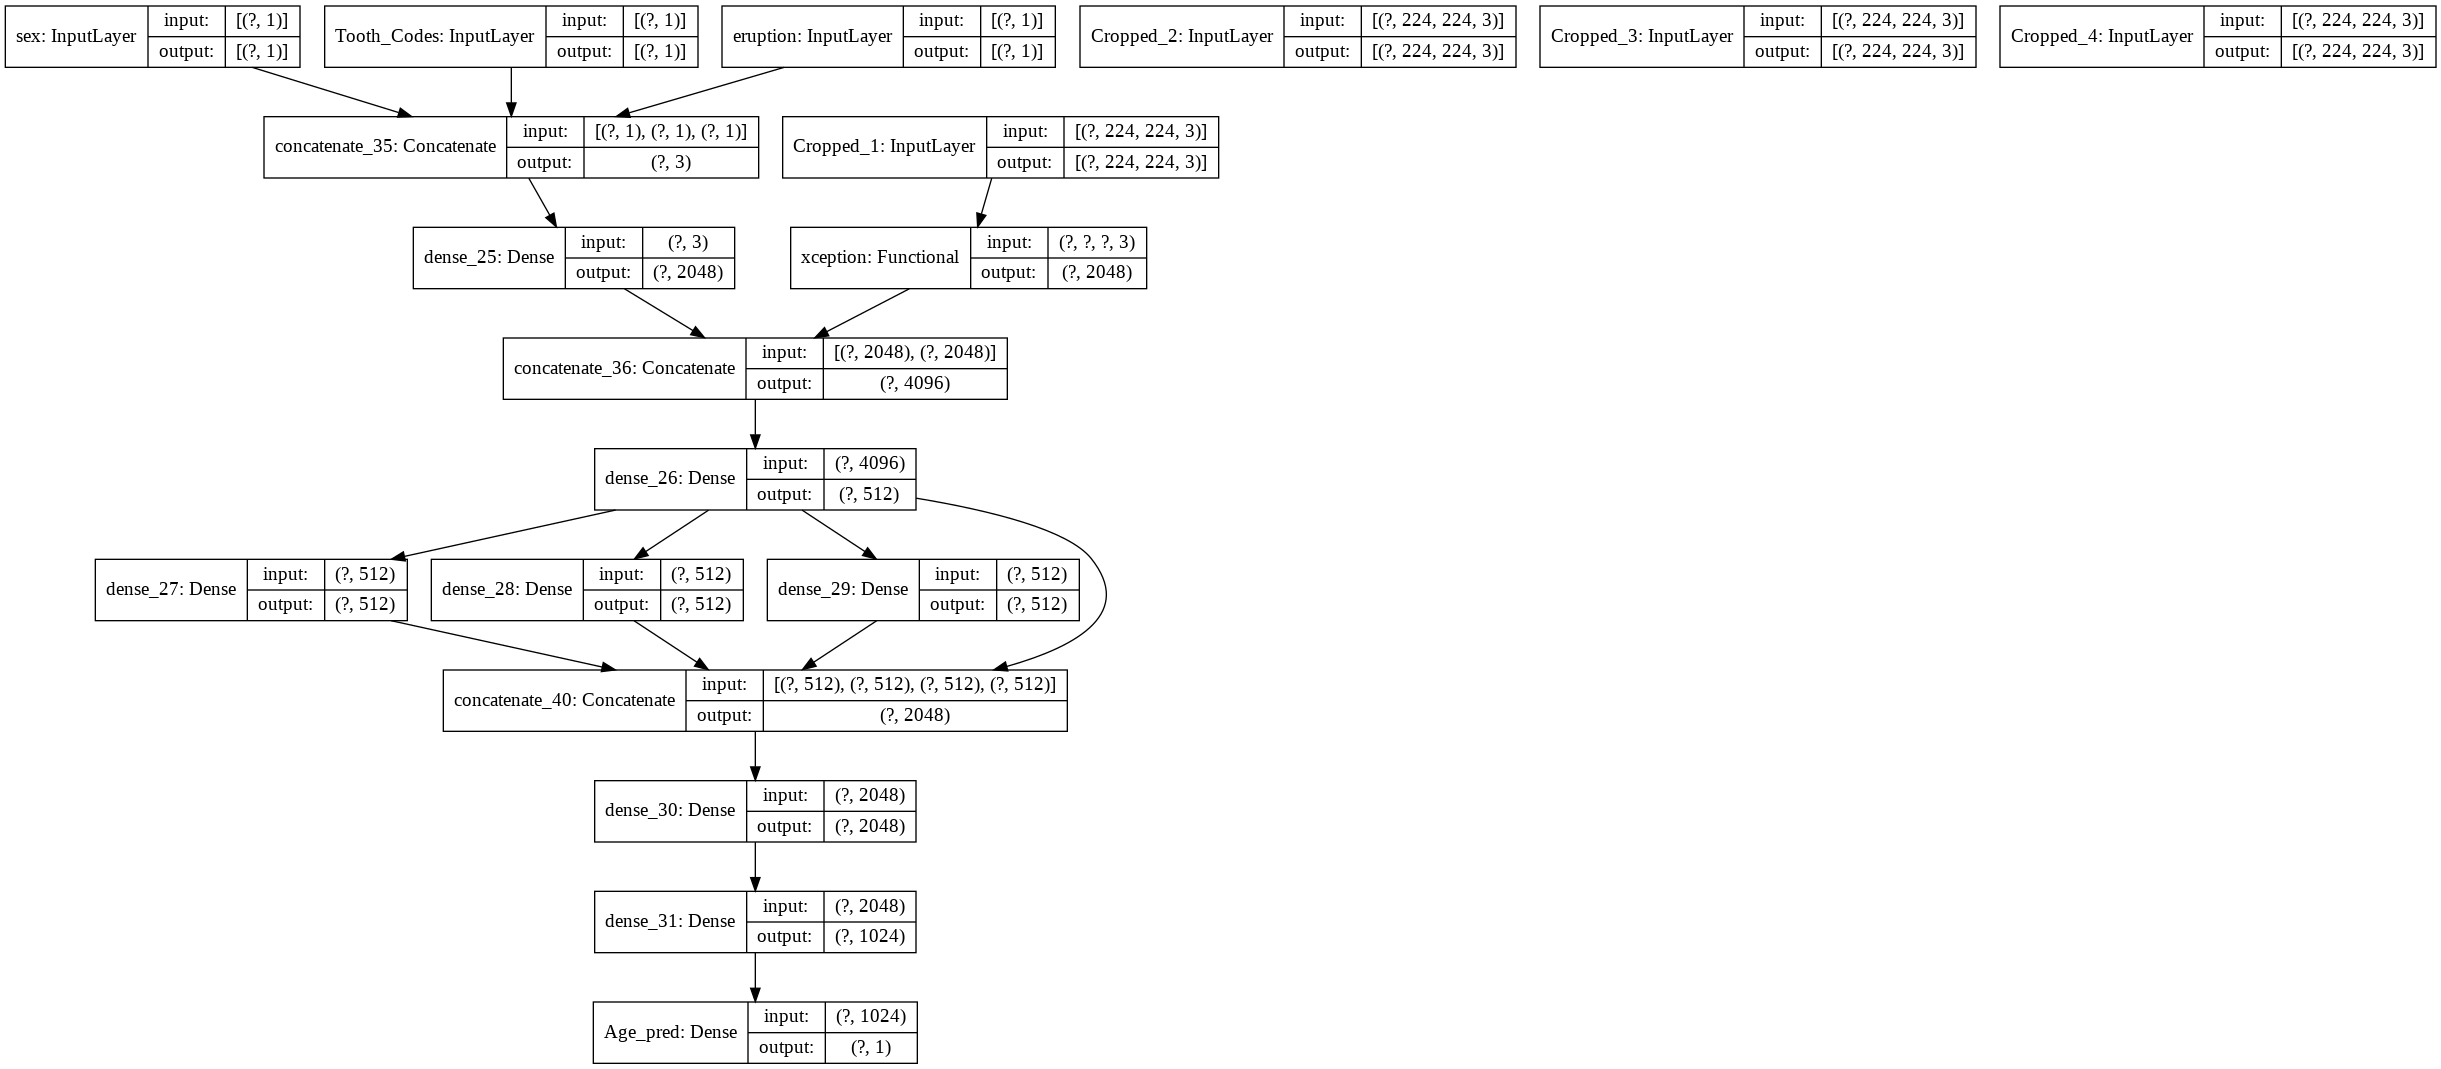

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [ ]:
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_4_slices.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/models/checkpoint_for_image_segmentation.ckpt


In [ ]:
model_3.load_weights(latest)

In [ ]:
#Loss function needs to be the Mean_squared error
loss = "MeanSquaredError"

#metrics for measurement
metrics = ['RootMeanSquaredError']

#Optimizer is going to the Adam, because it is the best performing
Optimizer = Adam(learning_rate= 1e-5)

In [ ]:
#model checkpoint
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_4_slices.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
#EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-7)
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger("training_sliced_images.log", append = True)

callbacks = [tboard_callback, reduce_lr, csv_logger, early_stop, checkpoint]

In [ ]:
model_3.compile(optimizer= Optimizer, loss = loss, metrics= metrics)

In [ ]:
epochs = 30

history = model_3.fit(train_generator,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    shuffle = 'batch',
                    callbacks=callbacks,
                    max_queue_size = 32,
                    validation_data=valid_generator,
                    validation_steps=len(valid_idx)//valid_batch_size
                    )

Epoch 1/30
19/19 [==============================] - 138s 7s/step - loss: 1471.1667 - root_mean_squared_error: 38.3558 - val_loss: 241.9360 - val_root_mean_squared_error: 15.5543
Epoch 2/30
19/19 [==============================] - 135s 7s/step - loss: 264.8711 - root_mean_squared_error: 16.2749 - val_loss: 248.9389 - val_root_mean_squared_error: 15.7778
Epoch 3/30
19/19 [==============================] - 136s 7s/step - loss: 249.8141 - root_mean_squared_error: 15.8055 - val_loss: 238.8211 - val_root_mean_squared_error: 15.4538
Epoch 4/30
19/19 [==============================] - 135s 7s/step - loss: 237.1674 - root_mean_squared_error: 15.4002 - val_loss: 222.1770 - val_root_mean_squared_error: 14.9056
Epoch 5/30
19/19 [==============================] - 131s 7s/step - loss: 229.8542 - root_mean_squared_error: 15.1609 - val_loss: 225.9667 - val_root_mean_squared_error: 15.0322
Epoch 6/30
19/19 [==============================] - 131s 7s/step - loss: 229.5110 - root_mean_squared_error: 15.14

In [ ]:
pred = model_3.predict(test_generator, steps=len(test_idx)//test_batch_size)

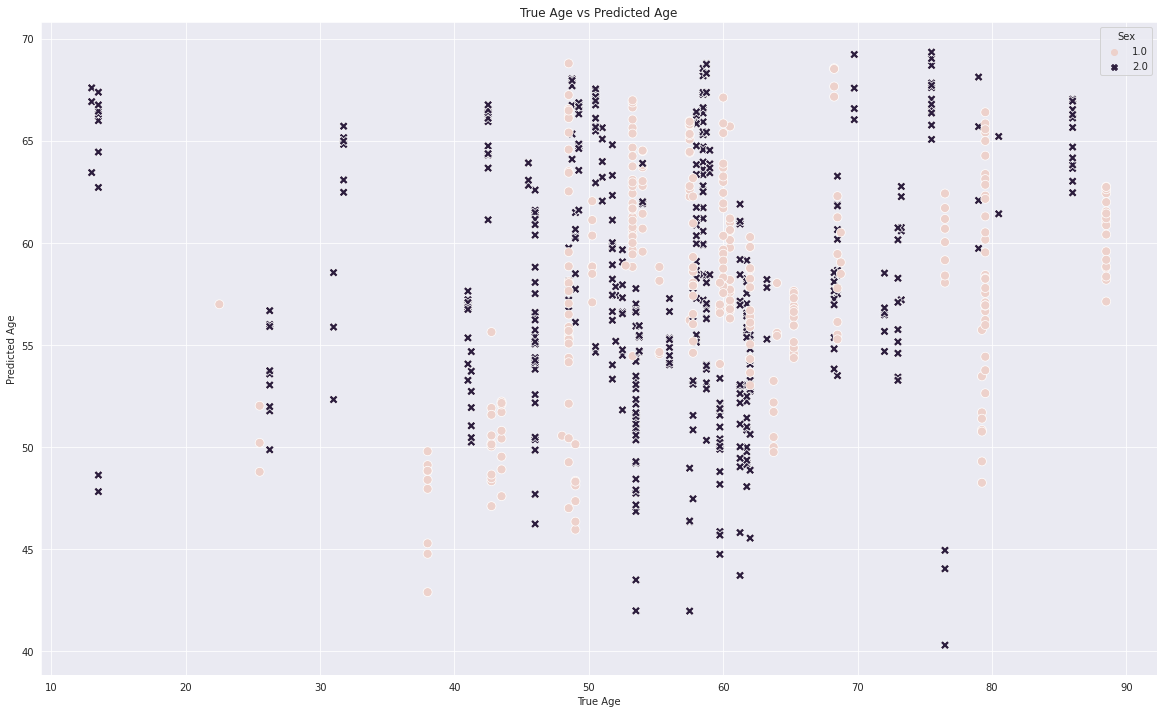

In [ ]:
fig = plt.gcf()
sns.set_style("darkgrid")
fig.set_size_inches(20, 12)
test_labels = data.iloc[test_idx]
ax = sns.scatterplot(x = test_labels['Age'], y = pred.flatten(), hue = test_labels['Sex'], style = test_labels['Sex'], edgecolor = 'w', s = 80,)
ax.set(xlabel='True Age', ylabel='Predicted Age', title = "True Age vs Predicted Age")